In [1]:
from Scripts import *

### Extract Symbol (i.e Spade/Heart etc...) from bboxed cards

In [5]:
example = cv2.imread('./media/cropped_images/game1/0r1.jpg')

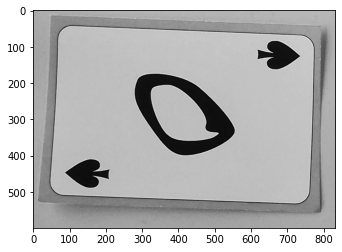

In [17]:
plt.imshow(example[:,:,1],cmap='gray')

In [56]:
threshed = (example[:,:,1] < 100) * 255

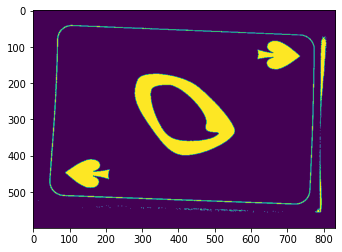

In [60]:
plt.imshow(threshed)

In [63]:
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(threshed.astype(np.uint8), 4)

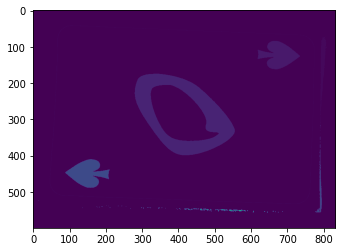

In [64]:
plt.imshow(labels_im)

In [74]:
centroids[1]

array([393.94709866, 305.81530295])

In [75]:
_, r1, r2, r3, r4 = np.array(sorted([(idx,val) for idx,val 
                 in enumerate(stats[:,-1])],
                key=lambda x:x[1],reverse=True))[:,0][:5]

In [80]:
# use centroids to get rid of card boundary
figure = (labels_im == r1)
sym1 = (labels_im == r2)
sym2 = (labels_im == r3)
sym3 = (labels_im == r4)

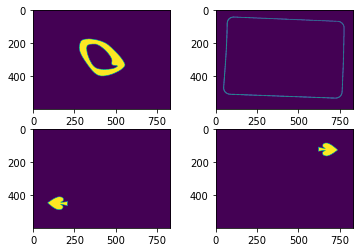

In [81]:
fig,ax = plt.subplots(2,2)
ax[0,0].imshow(figure)
ax[0,1].imshow(sym1)
ax[1,0].imshow(sym2)
ax[1,1].imshow(sym3)

In [87]:
x1,x2,y1,y2 = get_rectanglecoords(sym3)

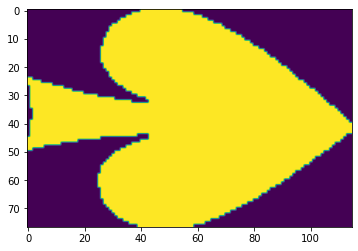

In [89]:
plt.imshow(sym3[y1:y2,x1:x2])

In [92]:
moments = cv2.moments(sym3[y1:y2,x1:x2].astype(np.uint8)) 
huMoments = cv2.HuMoments(moments)
huMoments

array([[ 1.85155206e-01],
       [ 3.04923353e-03],
       [ 3.89074889e-05],
       [ 2.60000026e-05],
       [-8.26863953e-10],
       [ 1.43549527e-06],
       [ 1.15860021e-11]])